In [1]:
from datetime import datetime, timezone

import numpy as np

from btopt import Engine, ExtendedDecimal, Order, Strategy
from btopt.indicators import SimpleMovingAverage
from btopt.util import logger_test, logger_main

In [2]:
def parse_date(epoch):
    return datetime.fromtimestamp(epoch / 1_000_000_000, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S")


class SimpleMovingAverageCrossover(Strategy):
    def __init__(self, fast_period: int = 20, slow_period: int = 50, risk_percent=0.01):
        super().__init__()

        self.fast_ma = 0
        self.slow_ma = 0

        self.risk_percentage = risk_percent
        self.fast_sma = SimpleMovingAverage(
            name="SMA_FAST",
            period=fast_period,
            source="close",
        )
        self.slow_sma = SimpleMovingAverage(
            name="SMA_SLOW",
            period=slow_period,
            source="close",
        )

        self.add_indicator(self.fast_sma)
        self.add_indicator(self.slow_sma)

        self.total = 0

    def on_data(self) -> None:
        bar = self.datas[self._primary_symbol].get(index=0)
        fast_ma = self.fast_sma.outputs[self._primary_symbol]["sma"][0]
        slow_ma = self.slow_sma.outputs[self._primary_symbol]["sma"][0]

        fast_ma_1 = self.fast_sma.outputs[self._primary_symbol]["sma"][1]
        slow_ma_1 = self.slow_sma.outputs[self._primary_symbol]["sma"][1]

        current_position = self.get_current_position(bar.ticker)

        if (not np.isnan(fast_ma_1)) and (not np.isnan(slow_ma_1)):
            prev_diff = fast_ma_1 - slow_ma_1
            diff = fast_ma - slow_ma

            if (diff > 0) and (prev_diff <= 0):
                # Bullish crossover
                if current_position == 0:
                    position_size = self.calculate_position_size(
                        bar.ticker,
                        bar.close,
                        # bar.close * 0.97,
                    )
                     
                    size = abs(current_position) + position_size
                    order = self.buy(
                        bar,
                        size,
                        stop_loss=bar.close * 0.97,
                        take_profit=bar.close * 1.01,
                    )

                    logger_main.warning(f"\n\n----- NEW LONG SIGNAL -----\n {order}\nCALCULATED SIZE: {size}\n")
                    self.total += 1
            elif (diff < 0) and (prev_diff >= 0):
                # Bearish crossover
                if current_position == 0:
                    position_size = self.calculate_position_size(
                        bar.ticker,
                        bar.close,
                        # bar.close * 1.03,
                    )

                    size = abs(current_position) + position_size
                    order = self.sell(
                        bar,
                        size,
                        stop_loss=bar.close * 1.03,
                        take_profit=bar.close * 0.99,
                    )
                    logger_main.warning(f"\n\n----- NEW SHORT SIGNAL -----\n {order}\nCALCULATED SIZE: {size}\nTIMESTAMP:" +
                                        f"{parse_date(bar.timestamp)}\nENGINE TIMESTAMP: {self._engine._current_timestamp}\n\n")
                    self.total += 1

    def on_order_update(self, order: Order) -> None:
        ...

    def on_trade_update(self, trade) -> None:
        if trade.status == trade.Status.CLOSED:
            logger_test.info(
                f"--------- TRADE COMPLETED -----------\n\
                ID: {trade.id}\n\
                DIRECTION: {trade.direction}\n\
                SIZE: {trade.initial_size}\n\n\
                ENTRY_TIME: {trade.entry_timestamp}\n\
                ENTRY_PRICE: {trade.entry_price}\n\
                TP_PRICE: {trade.entry_price * 1.01 if trade.direction == Order.Direction.LONG else trade.entry_price * 0.99}\n\
                SL_PRICE: {trade.entry_price * 0.97 if trade.direction == Order.Direction.LONG else trade.entry_price * 1.03}\n\n\
                EXIT_TIME: {trade.exit_timestamp}\n\
                EXIT_PRICE: {trade.exit_price}\n\
                PNL: {trade.metrics.pnl}\n\
                ---------------------------------------\n\
                \n\n\
                "
            )

In [3]:
from btopt.data.dataloader import CSVDataLoader


def run_backtest():
    # Initialize the engine
    engine = Engine()

    # Load data

    start_date = "2024-01-01"
    end_date = "2024-05-31"

    symbol = "BTCUSDT"
    dataloader = CSVDataLoader(symbol, "1m", start_date=start_date, end_date=end_date)
    engine.resample_data(dataloader, "1h")

    # symbol = "ES=F"
    # dataloader = YFDataloader(symbol, "1d", start_date=start_date, end_date=end_date)
    # engine.add_data(dataloader)

    # engine.add_strategy(Empty, ctf, htf)
    engine.add_strategy(SimpleMovingAverageCrossover, fast_period=20, slow_period=50)

    # Set up the backtest configuration

    initial_capital = ExtendedDecimal("100000")
    commission_rate = ExtendedDecimal("0")
    config = {
        "initial_capital": initial_capital,
        "commission_rate": commission_rate,
    }
    engine.set_config(config)

    # Run the backtest
    try:
        logger_test.info("Starting backtest")
        reporter = engine.run()

        return reporter
    except Exception as e:
        logger_test.error(f"Error during backtest: {e}", exc_info=True)

In [4]:
reporter = run_backtest()

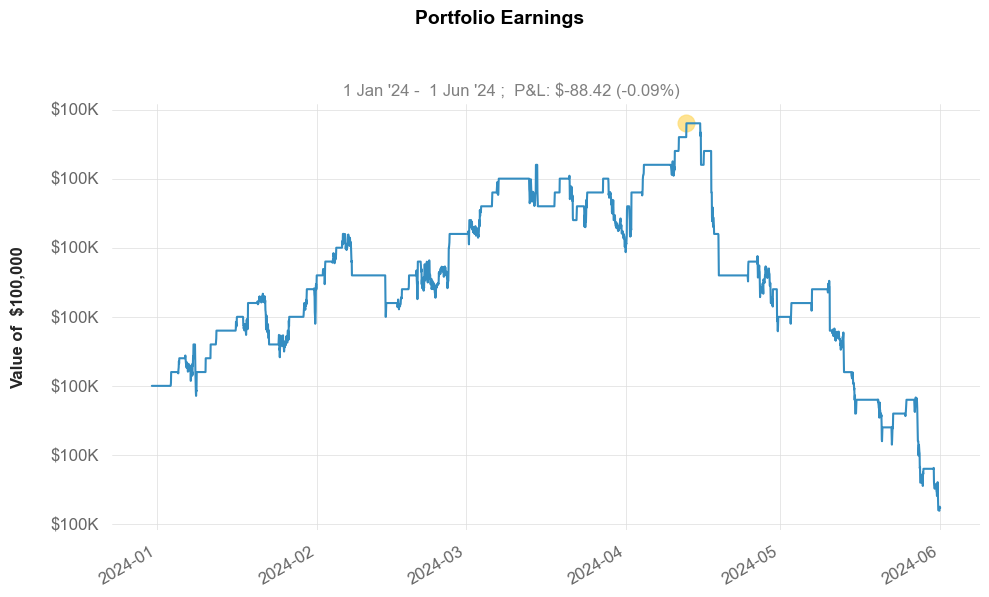

In [5]:
reporter.plot_equity_curve()

In [6]:
c = reporter.get_metrics_data()
c

,timestamp,cash,equity,asset_value,liabilities,open_pnl,closed_pnl,portfolio_return
0,2024-01-01 00:00:00,100000.000000,100000.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,2024-01-01 00:00:00,100000.000000,100000.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,2024-01-01 01:00:00,100000.000000,100000.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,2024-01-01 02:00:00,100000.000000,100000.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,2024-01-01 03:00:00,100000.000000,100000.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
3645,2024-05-31 20:00:00,99909.991207,99909.577336,0.0,999.385430,-0.413870,-90.008793,-0.000004
3646,2024-05-31 21:00:00,99909.991207,99911.704695,0.0,997.258072,1.713488,-90.008793,0.000021
3647,2024-05-31 22:00:00,99909.991207,99912.522252,0.0,996.440515,2.531045,-90.008793,0.000008
3648,2024-05-31 23:00:00,99909.991207,99912.072219,0.0,996.890548,2.081012,-90.008793,-0.000005


In [7]:
c = reporter.portfolio.get_trade_history()
c

,id,ticker,direction,initial_size,current_size,entry_price,entry_timestamp,exit_price,exit_timestamp,status,...,unrealized_pnl,pnl,pnl_percent,commission,slippage,max_runup,max_runup_percent,max_drawdown,max_drawdown_percent,strategy_id
0,1,BTCUSDT,SHORT,0.02325,0.00000,43000.01,2024-01-03T16:00:00,42570.0099,2024-01-03T18:00:00,CLOSED,...,0,9.997502325,1.00,0,0,9.997502325,1.00,0,0,995195f2-414b-4c87-a35e-5753af5df0e6
1,2,BTCUSDT,LONG,0.02298,0.00000,43506.01,2024-01-05T03:00:00,43941.060,2024-01-05T08:00:00,CLOSED,...,0,9.99744900,0.9999767848166264844788110884,0,0,9.99744900,0.9999767848166264844788110884,-0.9375840,-0.09378014669697359054530626918,995195f2-414b-4c87-a35e-5753af5df0e6
2,3,BTCUSDT,SHORT,0.02289,0.00000,43694.47,2024-01-06T11:00:00,43257.5352,2024-01-08T02:00:00,CLOSED,...,0,10.001437572,0.9999773426705942422462155966,0,0,10.001437572,0.9999773426705942422462155966,-16.3626876,-1.635996500243623506590193221,995195f2-414b-4c87-a35e-5753af5df0e6
3,4,BTCUSDT,SHORT,0.02287,0.00000,43720.45,2024-01-08T10:00:00,45032.0738,2024-01-08T12:00:00,CLOSED,...,0,-29.996836306,-3.000023558769408823559684312,0,0,0,0,-29.996836306,-3.000023558769408823559684312,995195f2-414b-4c87-a35e-5753af5df0e6
4,5,BTCUSDT,LONG,0.02216,0.00000,45111.1,2024-01-08T13:00:00,45562.2009,2024-01-08T17:00:00,CLOSED,...,0,9.996395944,0.9999776108319238502275493171,0,0,9.996395944,0.9999776108319238502275493171,-7.2505304,-0.7252982082015291136771215954,995195f2-414b-4c87-a35e-5753af5df0e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,67,BTCUSDT,LONG,0.01453,0.00000,68784.37,2024-05-25T05:00:00,69472.2137,2024-05-25T11:00:00,CLOSED,...,0,9.994368961,1.00,0,0,9.994368961,1.00,-1.8012841,-0.1802298981585496821443592491,995195f2-414b-4c87-a35e-5753af5df0e6
67,68,BTCUSDT,SHORT,0.01459,0.00000,68507.67,2024-05-27T00:00:00,70562.9001,2024-05-27T16:00:00,CLOSED,...,0,-29.985807159,-3.00,0,0,1.6696796,0.1670469890451682271488725277,-29.985807159,-3.00,995195f2-414b-4c87-a35e-5753af5df0e6
68,69,BTCUSDT,LONG,0.01428,0.00000,69985.49,2024-05-27T19:00:00,67885.935,2024-05-28T03:00:00,CLOSED,...,0,-29.98164540,-2.999986139984159573648766337,0,0,0,0,-29.98164540,-2.999986139984159573648766337,995195f2-414b-4c87-a35e-5753af5df0e6
69,70,BTCUSDT,SHORT,0.01465,0.00000,68208.64,2024-05-28T13:00:00,67526.5437,2024-05-28T18:00:00,CLOSED,...,0,9.992710795,1.000014514290271730971325627,0,0,9.992710795,1.000014514290271730971325627,-2.4236960,-0.2425499174298153430415853475,995195f2-414b-4c87-a35e-5753af5df0e6
